In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


📂 Step 1: Define Paths and Imports

In [2]:
!pip install torch torchvision timm scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [9]:
!pip install --upgrade timm


In [10]:
import timm
print("efficientnetv2_b0" in timm.list_models())



False


In [11]:
print("efficientnet_b0" in timm.list_models())

True


In [3]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import timm
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm


In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Paths
data_dir = '/content/drive/MyDrive/SDS/myconet/defungi_dataset'
model_save_path = '/content/drive/MyDrive/SDS/myconet/best_model.pth'


Using device: cuda


🧪 Step 2: Define Image Transforms & Load Dataset

Use strong augmentations for train, light for val/test

In [5]:
from torchvision import transforms

IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])


📂 Split Dataset

In [6]:
full_dataset = ImageFolder(root=data_dir)
class_names = full_dataset.classes
num_classes = len(class_names)

# Train/Val split
train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size

from torch.utils.data import random_split
train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

# Assign transforms
train_ds.dataset.transform = train_transform
val_ds.dataset.transform = val_transform

# Loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)


🧠 Step 3: Load Pretrained EfficientNet and Customize

In [12]:
model = timm.create_model('efficientnet_b0', pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model = model.to(device)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

If model.classifier doesn't exist, use:

In [ ]:
model.head = nn.Linear(model.head.in_features, num_classes)


🧮 Step 4: Define Loss, Optimizer, Scheduler

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.3, verbose=True)

checkpoint_path = "/content/drive/MyDrive/SDS/myconet/efficientnet_checkpoint.pth"


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🔁 Step 5: Train Loop with Validation and Early Stopping

In [14]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    best_acc = 0.0
    epochs_no_improve = 0
    start_epoch = 0

    for epoch in range(start_epoch, num_epochs):
        print(f"\n📘 Epoch {epoch + 1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            running_corrects += (outputs.argmax(1) == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_corrects += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)
        scheduler.step(val_loss)

        print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        # Save best model and checkpoint
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_acc': best_acc,
                'class_names': class_names
            }, checkpoint_path)
            print("✅ Best model saved!")

            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("⏹️ Early stopping due to no improvement.")
                break


# ---------------------------------------------
# ♻️ Resume Training (Optional Utility)
# ---------------------------------------------

def load_checkpoint(model, optimizer, scheduler, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    best_acc = checkpoint['best_acc']
    class_names = checkpoint.get('class_names', [])

    print(f"✅ Loaded checkpoint at epoch {epoch} with best acc: {best_acc:.4f}")
    return model, optimizer, scheduler, epoch + 1, best_acc, class_names


🔁 Run Training

In [15]:
train(model, train_loader, val_loader, criterion, optimizer, scheduler)


📘 Epoch 1/20


100%|██████████| 199/199 [32:48<00:00,  9.89s/it]


Train Loss: 0.7291, Acc: 0.7108
Val   Loss: 0.6134, Acc: 0.7718
✅ Best model saved!

📘 Epoch 2/20


100%|██████████| 199/199 [01:14<00:00,  2.66it/s]


Train Loss: 0.4603, Acc: 0.8242
Val   Loss: 0.5172, Acc: 0.7932
✅ Best model saved!

📘 Epoch 3/20


100%|██████████| 199/199 [01:15<00:00,  2.62it/s]


Train Loss: 0.3299, Acc: 0.8754
Val   Loss: 0.5210, Acc: 0.8222
✅ Best model saved!

📘 Epoch 4/20


100%|██████████| 199/199 [01:16<00:00,  2.59it/s]


Train Loss: 0.2725, Acc: 0.9042
Val   Loss: 0.4632, Acc: 0.8370
✅ Best model saved!

📘 Epoch 5/20


100%|██████████| 199/199 [01:15<00:00,  2.64it/s]


Train Loss: 0.2010, Acc: 0.9263
Val   Loss: 0.3650, Acc: 0.8734
✅ Best model saved!

📘 Epoch 6/20


100%|██████████| 199/199 [01:15<00:00,  2.63it/s]


Train Loss: 0.1611, Acc: 0.9394
Val   Loss: 0.4223, Acc: 0.8664

📘 Epoch 7/20


100%|██████████| 199/199 [01:14<00:00,  2.68it/s]


Train Loss: 0.1357, Acc: 0.9519
Val   Loss: 0.3758, Acc: 0.8962
✅ Best model saved!

📘 Epoch 8/20


100%|██████████| 199/199 [01:15<00:00,  2.64it/s]


Train Loss: 0.1195, Acc: 0.9609
Val   Loss: 0.3920, Acc: 0.8914

📘 Epoch 9/20


100%|██████████| 199/199 [01:13<00:00,  2.69it/s]


Train Loss: 0.0928, Acc: 0.9699
Val   Loss: 0.5120, Acc: 0.8568

📘 Epoch 10/20


100%|██████████| 199/199 [01:14<00:00,  2.68it/s]


Train Loss: 0.0503, Acc: 0.9822
Val   Loss: 0.2953, Acc: 0.9253
✅ Best model saved!

📘 Epoch 11/20


100%|██████████| 199/199 [01:15<00:00,  2.64it/s]


Train Loss: 0.0130, Acc: 0.9965
Val   Loss: 0.3186, Acc: 0.9216

📘 Epoch 12/20


100%|██████████| 199/199 [01:15<00:00,  2.65it/s]


Train Loss: 0.0104, Acc: 0.9968
Val   Loss: 0.3188, Acc: 0.9205

📘 Epoch 13/20


100%|██████████| 199/199 [01:13<00:00,  2.71it/s]


Train Loss: 0.0121, Acc: 0.9975
Val   Loss: 0.4320, Acc: 0.9076

📘 Epoch 14/20


100%|██████████| 199/199 [01:14<00:00,  2.68it/s]


Train Loss: 0.0191, Acc: 0.9940
Val   Loss: 0.3158, Acc: 0.9268
✅ Best model saved!

📘 Epoch 15/20


100%|██████████| 199/199 [01:16<00:00,  2.60it/s]


Train Loss: 0.0092, Acc: 0.9983
Val   Loss: 0.3510, Acc: 0.9212

📘 Epoch 16/20


100%|██████████| 199/199 [01:24<00:00,  2.37it/s]


Train Loss: 0.0072, Acc: 0.9978
Val   Loss: 0.3115, Acc: 0.9279
✅ Best model saved!

📘 Epoch 17/20


100%|██████████| 199/199 [01:16<00:00,  2.59it/s]


Train Loss: 0.0063, Acc: 0.9989
Val   Loss: 0.3198, Acc: 0.9271

📘 Epoch 18/20


100%|██████████| 199/199 [01:14<00:00,  2.66it/s]


Train Loss: 0.0070, Acc: 0.9983
Val   Loss: 0.2999, Acc: 0.9308
✅ Best model saved!

📘 Epoch 19/20


100%|██████████| 199/199 [01:16<00:00,  2.61it/s]


Train Loss: 0.0053, Acc: 0.9989
Val   Loss: 0.2852, Acc: 0.9301

📘 Epoch 20/20


100%|██████████| 199/199 [01:14<00:00,  2.68it/s]


Train Loss: 0.0048, Acc: 0.9991
Val   Loss: 0.2902, Acc: 0.9312
✅ Best model saved!


📊 Step 6: Evaluation & Confusion Matrix
Reload Best Model

In [20]:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

Collect Predictions

In [21]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

Plot Confusion Matrix

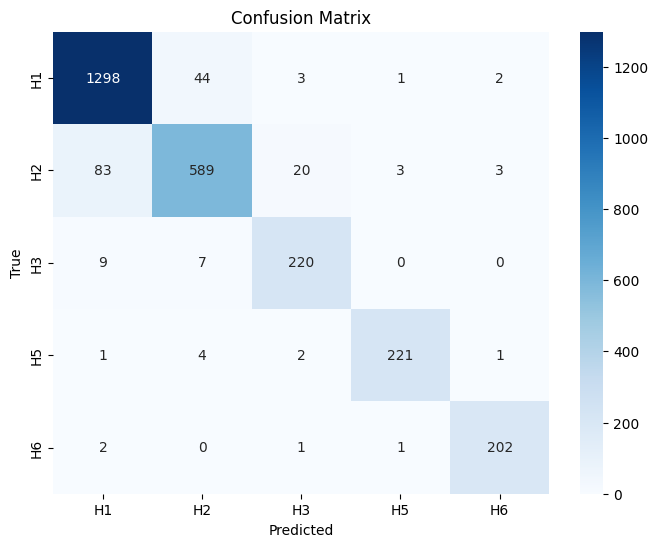

In [22]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Classification Report

In [23]:
print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

          H1       0.93      0.96      0.95      1348
          H2       0.91      0.84      0.88       698
          H3       0.89      0.93      0.91       236
          H5       0.98      0.97      0.97       229
          H6       0.97      0.98      0.98       206

    accuracy                           0.93      2717
   macro avg       0.94      0.94      0.94      2717
weighted avg       0.93      0.93      0.93      2717



🖼️ Step 7: Predict on a New Image

In [24]:
from PIL import Image

def predict_image(image_path):
    img = Image.open(image_path).convert("RGB")
    transform = val_transform
    img_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()

    print(f"Predicted class: {class_names[pred]}")


In [26]:
predict_image('/content/drive/MyDrive/SDS/myconet/defungi_dataset/H5/H5_102a_2.jpg')

Predicted class: H5
